In [1]:
import random
import numpy as np
import itertools

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [2]:
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [3]:
BATCH_SIZE = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("high")

In [4]:
START_TOKN = "<"
END_TOKN = ">"
MISS_TOKN = "*"
PAD_TOKN = "#"

In [5]:
def read(file):
    f = open(file, 'r', encoding='utf-8')
    data = f.read().splitlines()
    f.close()
    return data

train_data = read('train_data.txt')
val_data = read('val_data.txt')
len(train_data), len(val_data)

(204570, 22730)

In [6]:
MAX_WORD_LEN = max([len(w) for w in train_data]) + 1 # extra padding
BLOCK_SIZE = MAX_WORD_LEN + 2
MAX_WORD_LEN, BLOCK_SIZE

(30, 32)

In [7]:
CHARS = sorted(list(set("".join(train_data))) + [START_TOKN, END_TOKN, MISS_TOKN, PAD_TOKN])
"".join(CHARS)

'#*<>abcdefghijklmnopqrstuvwxyz'

In [8]:
stoi = {ch: i for i, ch in enumerate(CHARS)}
itos = {i: ch for i, ch in enumerate(CHARS)}

text = START_TOKN + "hello" + MISS_TOKN + "world" + PAD_TOKN + END_TOKN
tokns = [stoi[ch] for ch in text]
"".join([itos[i] for i in tokns])

'<hello*world#>'

In [9]:
def get_sample(w, min_length=1, max_length=0):
    letters = list(set(w))
    m, n = len(w), len(letters)
    
    if min_length <= 0:
        min_length = n - min_length
    if max_length <= 0:
        max_length = n - max_length
    min_length = max(1, min_length)
    max_length = min(n, max_length)
        
    subsets = []
    for r in range(min_length, max_length+1):
        subsets.extend(itertools.combinations(letters, r))
    
    missing_letters = random.choice(subsets)
    sample = "".join([w[i] if w[i] not in missing_letters else MISS_TOKN for i in range(m)])

    return sample, set(missing_letters)

get_sample(train_data[0])

('*f****xi*', {'a', 'l', 'n', 'o', 't'})

In [10]:
class HangManData(Dataset):
    def __init__(self, words, min_length=1, max_length=0):
        self.words = words
        self.min_length = min_length
        self.max_length = max_length

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        x_ch, y_ch = get_sample(word, self.min_length, self.max_length)

        x_tkn = (START_TOKN + x_ch + END_TOKN + PAD_TOKN * BLOCK_SIZE)[:BLOCK_SIZE]
        x = torch.tensor([stoi[c] for c in x_tkn], device=DEVICE)

        g = torch.zeros(len(CHARS), device=DEVICE)
        g_tkn = [stoi[c] for c in x_ch if c != MISS_TOKN]
        g[g_tkn] = 1.0

        y = torch.zeros(len(CHARS), device=DEVICE)
        y[[stoi[c] for c in y_ch]] = 1.0

        return (x, g, y)

In [11]:
@torch.no_grad()
def get_top_guess_batch(model, x, g):
    with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
        logits = model(x, g)                                          # (B, V)
    guesses = logits.argmax(dim=1)                                    # (B,)
    return guesses

In [12]:
def make_collate_fn(model, context_rounds):
    def collate_fn(batch):
        x_batch, g_batch, y_batch = zip(*batch)
        x = torch.stack(x_batch)
        g = torch.stack(g_batch)
        y = torch.stack(y_batch)

        for _ in range(context_rounds):
            guess_ids = get_top_guess_batch(model, x, g)              # (B,)
            newly_guessed = torch.zeros_like(g, device=DEVICE)        # (B, V)
            newly_guessed[torch.arange(g.size(0)), guess_ids] = 1.0   # (B, V)
            was_incorrect = (newly_guessed * y).sum(dim=1) == 0       # (B,)
            was_incorrect = was_incorrect.unsqueeze(1)                # (B, 1)
            new_g = torch.maximum(g, newly_guessed)                   # (B, V)
            g = torch.where(was_incorrect, new_g, g)

        return x, g, y
    return collate_fn

In [13]:
def get_loader(ds, model=None, context_rounds=0):
    if model is not None and context_rounds > 0:
        collate = make_collate_fn(model, context_rounds)
    else:
        collate = None  # default collate_fn (no guessing)

    loader = DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        sampler=RandomSampler(ds, replacement=True, num_samples=BATCH_SIZE),
        collate_fn=collate
    )
    return loader

In [14]:
class Attention(nn.Module):
    def __init__(self, emb=32, heads=4):
        super().__init__()
        self.heads = heads
        self.key = nn.Linear(emb, emb, bias=False)
        self.qry = nn.Linear(emb, emb)
        self.val = nn.Linear(emb, emb)
        self.proj = nn.Linear(emb, emb)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, z, attn_mask=None, rel_pos_emb=None):
        B, Tx, C = x.shape                                                # (B, Tx, C)
        Tz = z.shape[1]                                                   # (B, Tz, C)
        H = self.heads
        q = self.qry(x).view(B, Tx, H, C // H).transpose(1, 2)            # (B, H, Tx, C//H)
        k = self.key(z).view(B, Tz, H, C // H).transpose(1, 2)            # (B, H, Tz, C//H)
        v = self.val(z).view(B, Tz, H, C // H).transpose(1, 2)            # (B, H, Tz, C//H)
        att = (q @ k.transpose(-1, -2)) * (1.0 / np.sqrt(k.size(-1)))     # (B, H, Tx, Tz)
        if rel_pos_emb is not None:
            att += rel_pos_emb                                            # (B, H, Tx, Tz)
        if attn_mask is not None:
            att = att.masked_fill(attn_mask == 1, -1e9)                   # (B, H, Tx, Tz)
        att = self.dropout(F.softmax(att, dim=-1))                        # (B, H, Tx, Tz)
        y = (att @ v).transpose(1, 2)                                     # (B, Tx, H, C//H)
        y = y.contiguous().view(B, Tx, C)                                 # (B, Tx, C)
        y = self.dropout(self.proj(y))                                    # (B, Tx, C)
        return y

In [15]:
class FeedForward(nn.Module):
    def __init__(self, emb=32, mlp_emb=128):
        super().__init__()
        self.lin = nn.Linear(emb, mlp_emb)
        self.proj = nn.Linear(mlp_emb, emb)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):                                                    # (B, T, C)
        x = self.lin(x)                                                      # (B, T, M)
        x = F.gelu(x)                                                        # (B, T, M)
        y = self.proj(x)                                                     # (B, T, C)
        y = self.dropout(y)                                                  # (B, T, C)
        return y

In [16]:
class RelativePositionBias(nn.Module):
    def __init__(self, heads=4, block_size=BLOCK_SIZE):
        super().__init__()
        self.block_size = block_size
        self.bias = nn.Embedding(2*block_size+1, heads)
        
    def forward(self, Tx, Tz):
        pos = torch.arange(Tx, device=DEVICE)
        rel_pos = pos[:, None] - pos[None, :]                                # (Tx, Tz)
        rel_pos = rel_pos + self.block_size                                  # (Tx, Tz)
        bias = self.bias(rel_pos)                                            # (Tx, Tz, H)
        return bias.permute(2, 0, 1)                                         # (H, Tx, Tz)

In [17]:
class Block(nn.Module):
    def __init__(self, emb=32, heads=4, mlp_emb=128, x_attn=False, rel_pos=False):
        super().__init__()
        self.self_norm = nn.LayerNorm(emb)
        self.self_attn = Attention(emb, heads)
        self.self_res_scale = nn.Parameter(torch.tensor(0.1))
        self.feed_fwd_norm = nn.LayerNorm(emb)
        self.feed_fwd = FeedForward(emb, mlp_emb)
        self.feed_fwd_res_scale = nn.Parameter(torch.tensor(0.1))
        self.x_attn = x_attn
        if self.x_attn:
            self.cross_norm = nn.LayerNorm(emb)
            self.cross_attn = Attention(emb, heads)
            self.cross_res_scale = nn.Parameter(torch.tensor(0.1))
        self.rel_pos = rel_pos
        if self.rel_pos:
            self.rel_pos_bias = RelativePositionBias(heads) 
            
    def forward(self, x, z=None, self_mask=None, x_mask=None):
        nx = self.self_norm(x)                                              # (B, Tx, C)
        rel_pos_emb = None
        if self.rel_pos:
            rel_pos_emb = self.rel_pos_bias(nx.size(1), nx.size(1))         # (H, Tx, Tx)
            rel_pos_emb = rel_pos_emb.unsqueeze(0)                          # (1, H, Tx, Tx)
        self_attn = self.self_attn(nx, nx, self_mask, rel_pos_emb)          # (B, Tx, C)
        attn = x + self.self_res_scale * self_attn                          # (B, Tx, C)
        if self.x_attn:
            nx = self.cross_norm(attn)                                      # (B, Tx, C)
            x_attn = self.cross_attn(nx, z, x_mask)                         # (B, Tx, C)
            attn = attn + self.cross_res_scale * x_attn                     # (B, Tx, C)
        nx = self.feed_fwd_norm(attn)                                       # (B, Tx, C)
        ff = attn + self.feed_fwd_res_scale * self.feed_fwd(nx)             # (B, Tx, C)
        return ff

In [18]:
class Transformer(nn.Module):
    def __init__(self, emb=32, heads=4, mlp_emb=128, decoder_layers=4, encoder_layers=2):
        super().__init__()
        self.char_embed = nn.Embedding(len(CHARS), emb)
        self.guess_embed = nn.Linear(len(CHARS), emb)
        
        self.guess_blocks = nn.Sequential(*[Block(emb, heads, mlp_emb) for _ in range(encoder_layers)])
        self.decoder_blocks = nn.ModuleList([Block(emb, heads, mlp_emb, True, True) for _ in range(decoder_layers)])
        
        self.decoder_norm = nn.LayerNorm(emb)
        self.decoder = nn.Linear(emb, len(CHARS), bias=False)
        self.decoder.weight = self.char_embed.weight

        self.activations = {}
        self.gradients = {}
        self._register_hooks()


    def forward(self, x, g):
        B, T = x.shape                                                        # (B, T)
        char_emb = self.char_embed(x)                                         # (B, T, C)
        g_emb = self.guess_embed(g).unsqueeze(1).expand(-1, T, -1)            # (B, T, C)

        pos_mask = (x == stoi[PAD_TOKN])                                      # (B, T)
        attn_mask = pos_mask.unsqueeze(1) | pos_mask.unsqueeze(2)             # (B, T, T)
        attn_mask = attn_mask.unsqueeze(1)                                    # (B, 1, T, T)
        
        qry_mask = pos_mask.unsqueeze(1).unsqueeze(2)                         # (B, 1, 1, T)
        qry_mask = qry_mask.expand(-1, -1, T, -1)                             # (B, 1, T, T)
        
        g_z = self.guess_blocks(g_emb)                                        # (B, T, C)
        out = char_emb                                                        # (B, T, C)
        for block in self.decoder_blocks:
            out = block(out, g_z, self_mask=attn_mask, x_mask=qry_mask)       # (B, T, C)  
        
        out = self.decoder_norm(out)                                          # (B, T, C)
        out = self.decoder(out)                                               # (B, T, V)
        out = out.transpose(-1, -2)                                           # (B, V, T)
        decoder_mask = (x == stoi[MISS_TOKN])                                 # (B, T)
        num_masked = decoder_mask.sum(dim=1, keepdim=True)                    # (B, 1)
        masked_out = out.masked_fill(~decoder_mask.unsqueeze(1), 0.0)         # (B, V, T)
        logits = masked_out.sum(dim=-1) / num_masked                          # (B, V)        
        return logits
    
    
    def _save_activation(self, name):
        def hook(module, input, output):
            self.activations[name] = output.detach()
        return hook

    def _save_gradient(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0].detach()
        return hook        
    
    def _register_hooks(self):
        # Register forward hooks for embeddings
        self.char_embed.register_forward_hook(self._save_activation("char_embed_out"))
        self.guess_embed.register_forward_hook(self._save_activation("guess_embed_out"))

        # Guess encoder blocks
        for i, block in enumerate(self.guess_blocks):
            name = f"guess_block_{i+1}"
            block.register_forward_hook(self._save_activation(f"{name}_out"))
            if hasattr(block, "self_attn"):
                block.self_attn.register_forward_hook(self._save_activation(f"{name}_self_attn_out"))
                block.self_attn.register_full_backward_hook(self._save_gradient(f"{name}_self_attn_grad"))
            if hasattr(block, "feed_fwd"):
                block.feed_fwd.register_forward_hook(self._save_activation(f"{name}_ffn_out"))
                block.feed_fwd.register_full_backward_hook(self._save_gradient(f"{name}_ffn_grad"))

        # Decoder blocks
        for i, block in enumerate(self.decoder_blocks):
            name = f"decoder_block_{i+1}"
            block.register_forward_hook(self._save_activation(f"{name}_out"))
            if hasattr(block, "self_attn"):
                block.self_attn.register_forward_hook(self._save_activation(f"{name}_self_attn_out"))
                block.self_attn.register_full_backward_hook(self._save_gradient(f"{name}_self_attn_grad"))
            if hasattr(block, "cross_attn"):
                block.cross_attn.register_forward_hook(self._save_activation(f"{name}_cross_attn_out"))
                block.cross_attn.register_full_backward_hook(self._save_gradient(f"{name}_cross_attn_grad"))
            if hasattr(block, "rel_pos_bias"):
                block.rel_pos_bias.register_forward_hook(self._save_activation(f"{name}_rel_pos_bias_out"))
                block.rel_pos_bias.register_full_backward_hook(self._save_gradient(f"{name}_rel_pos_bias_grad"))                    
            if hasattr(block, "feed_fwd"):
                block.feed_fwd.register_forward_hook(self._save_activation(f"{name}_ffn_out"))
                block.feed_fwd.register_full_backward_hook(self._save_gradient(f"{name}_ffn_grad"))

        # Final layers
        self.decoder_norm.register_forward_hook(self._save_activation("decoder_norm_out"))
        self.decoder_norm.register_full_backward_hook(self._save_gradient("decoder_norm_grad"))
        self.decoder.register_forward_hook(self._save_activation("decoder_out"))
        self.decoder.register_full_backward_hook(self._save_gradient("decoder_grad"))

In [19]:
@torch.no_grad
def get_accuracy(logits, y):
    preds = logits.argmax(dim=1)
    correct = y[torch.arange(y.size(0)), preds]
    acc = correct.float().mean().item()
    return acc

In [20]:
def train(model, loader, optimizer, steps=10**2):
    criterion = nn.BCEWithLogitsLoss()
    stats = {"loss": [], "ratio": [], "accuracy": []}
    model.train()

    for _ in range(steps):
        x, g, y = next(iter(loader))
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = model(x, g)
            loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            stats["loss"].append(loss.item())
            ratios = []
            for p in model.parameters():
                if p.grad is None:
                    continue
                lr = optimizer.param_groups[0]['lr']
                update_mean = ((lr * p.grad)**2).mean().item()
                weight_mean = ((p.data)**2).mean().item()
                if weight_mean == 0:
                    ratios.append(np.nan)
                else:
                    ratios.append(update_mean/weight_mean)
            stats["ratio"].append(ratios)
            accuracy = get_accuracy(logits, y)
            stats["accuracy"].append(accuracy)
    return stats

In [21]:
@torch.no_grad()
def validate(model, loader, steps=10):
    criterion = nn.BCEWithLogitsLoss()
    stats = {"loss": [], "accuracy": []}
    model.eval()

    for _ in range(steps):
        x, g, y = next(iter(loader))
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits = model(x, g)
            loss = criterion(logits, y)
        stats["loss"].append(loss.item())
        accuracy = get_accuracy(logits, y)
        stats["accuracy"].append(accuracy)
    return stats

In [22]:
@torch.no_grad()
def predict(model, word, guessed):
    model.eval()

    word =  word.replace(".", MISS_TOKN)
    x_ch = (START_TOKN + word + END_TOKN + PAD_TOKN*BLOCK_SIZE)[:BLOCK_SIZE]
    x = torch.tensor([stoi[ch] for ch in x_ch], device=DEVICE)
    g = torch.zeros(len(CHARS), device=DEVICE)
    g_tkn = [stoi[ch] for ch in guessed + list(word) if ch != MISS_TOKN]
    g[g_tkn] = 1.0
    logits = model(x.unsqueeze(0), g.unsqueeze(0))
    logits = logits.squeeze(0)

    preds = {itos[i]: logits[i].item() for i in range(len(logits))}
    return sorted(preds.items(), key=lambda item: item[1], reverse=True)

In [23]:
def initialize_weights(model):
    if isinstance(model, nn.Linear):
        init.xavier_uniform_(model.weight)
        if model.bias is not None:
            init.zeros_(model.bias)

    elif isinstance(model, nn.Embedding):
        init.normal_(model.weight, mean=0.0, std=1)

    elif isinstance(model, nn.LayerNorm):
        init.ones_(model.weight)
        init.zeros_(model.bias)

    elif isinstance(model, nn.Parameter):
        init.normal_(model.data, mean=0.0, std=0.02)

In [24]:
def train_and_validate(epochs, model, train_loader, val_loader, optimizer):
    print("Training...")
    for epoch in range(epochs):
        train_stats = train(model, train_loader, optimizer)
        stats["loss"].extend(train_stats["loss"])
        stats["ratio"].extend(train_stats["ratio"])
        stats["accuracy"].extend(train_stats["accuracy"])
        train_loss = sum(train_stats["loss"])/len(train_stats["loss"])
        train_acc = sum(train_stats["accuracy"])/len(train_stats["accuracy"])
        if (((epoch+1) % max(1, (epochs//10))) == 0) or (epoch+1 == epochs):
            val_stats = validate(model, val_loader)
            val_loss = sum(val_stats["loss"])/len(val_stats["loss"])
            val_acc = sum(val_stats["accuracy"])/len(val_stats["accuracy"])
            print(f"""Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f},
                  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Total Steps: {len(stats["loss"])}""")

In [25]:
stats = {"loss": [], "ratio": [], "accuracy": []}

model = Transformer(emb=256, heads=8, mlp_emb=1024, decoder_layers=8, encoder_layers=4)
initialize_weights(model)
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.to(DEVICE)

sum(p.numel() for p in model.parameters())

11601760

In [26]:
train_ds = HangManData(train_data)
val_ds = HangManData(val_data)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [27]:
train_loader = get_loader(train_ds, model, context_rounds=0)
val_loader = get_loader(val_ds, model, context_rounds=0)
train_and_validate(5, model, train_loader, val_loader, optimizer)

Training...
Epoch: 1, Training Loss: 0.1964, Training Acc: 0.7561,
                  Val Loss: 0.1971, Val Acc: 0.7461, Total Steps: 100
Epoch: 2, Training Loss: 0.1948, Training Acc: 0.7553,
                  Val Loss: 0.1992, Val Acc: 0.7536, Total Steps: 200
Epoch: 3, Training Loss: 0.1955, Training Acc: 0.7552,
                  Val Loss: 0.1987, Val Acc: 0.7539, Total Steps: 300
Epoch: 4, Training Loss: 0.1943, Training Acc: 0.7566,
                  Val Loss: 0.1970, Val Acc: 0.7523, Total Steps: 400
Epoch: 5, Training Loss: 0.1946, Training Acc: 0.7576,
                  Val Loss: 0.1976, Val Acc: 0.7490, Total Steps: 500


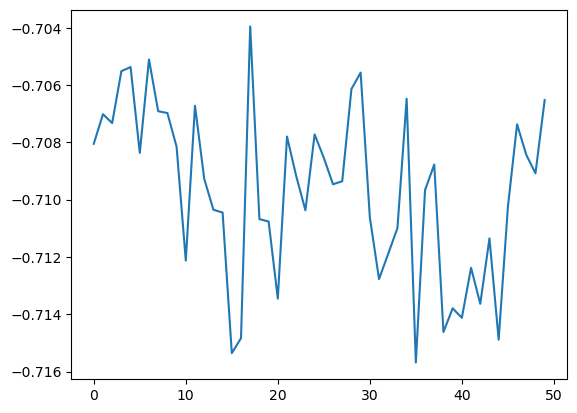

In [28]:
losses = torch.tensor(stats["loss"]).view(-1, 10)
plt.plot(losses.mean(dim=1).log10())
plt.show()

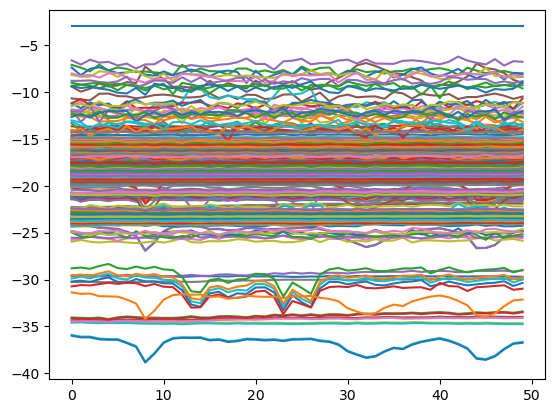

In [29]:
raw_ratios = torch.tensor(stats["ratio"])
ratios = torch.tensor(stats["ratio"]).view(-1, 10, raw_ratios.size(1)).log10()
e3 = torch.ones(ratios.size(0))*(-3)
plt.plot(e3)
plt.plot(ratios.mean(dim=1))
plt.show()

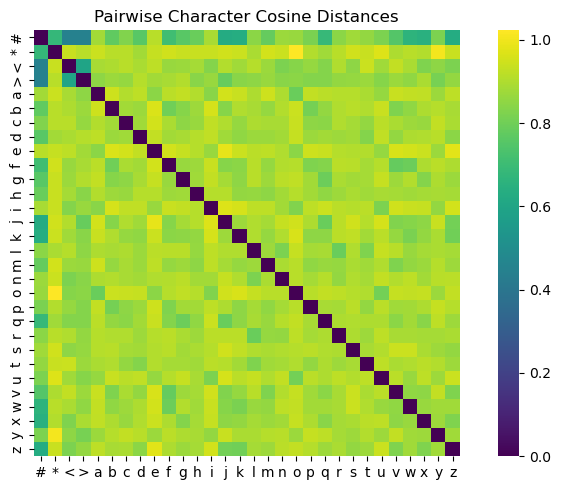

In [30]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

def plot_char_similarity_matrix(char_embedding, chars=CHARS, metric="cosine"):
    emb = char_embedding.weight.detach().cpu().numpy()
    dist = squareform(pdist(emb, metric=metric))
    plt.figure(figsize=(8, 5))
    sns.heatmap(dist, xticklabels=chars, yticklabels=chars, cmap="viridis", square=True)
    plt.title(f"Pairwise Character {metric.capitalize()} Distances")
    plt.tight_layout()
    plt.show()
    
plot_char_similarity_matrix(model.char_embed)

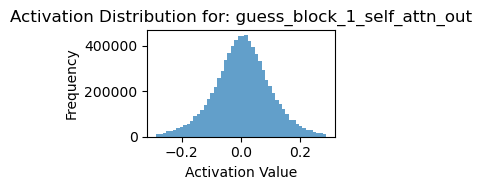

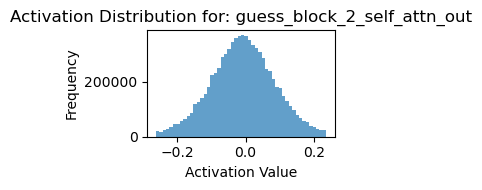

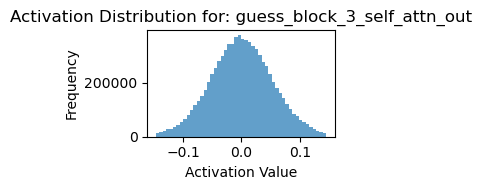

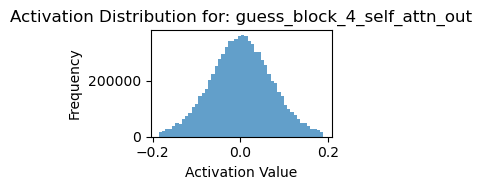

In [31]:
for name, activation in model.activations.items():
    if not ('guess_block' in name and 'self_attn_out' in name):
        continue
    data = activation.flatten().float().cpu().numpy()
    lower, upper = np.percentile(data, [1, 99])  # clip outside 1%-99% range
    clipped_data = data[(data >= lower) & (data <= upper)]
    
    plt.figure(figsize=(3, 2))
    plt.hist(clipped_data, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f'Activation Distribution for: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

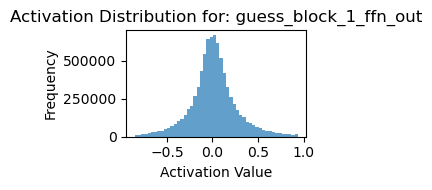

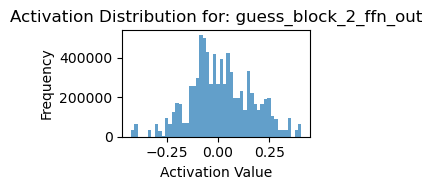

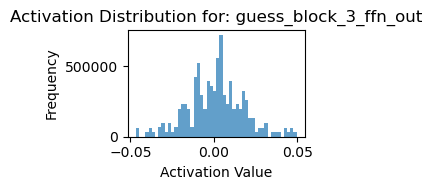

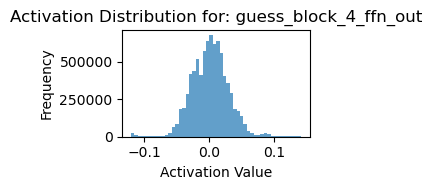

In [32]:
for name, activation in model.activations.items():
    if not ('guess_block' in name and 'ffn_out' in name):
        continue
    data = activation.flatten().float().cpu().numpy()
    lower, upper = np.percentile(data, [1, 99])  # clip outside 1%-99% range
    clipped_data = data[(data >= lower) & (data <= upper)]
    
    plt.figure(figsize=(3, 2))
    plt.hist(clipped_data, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f'Activation Distribution for: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

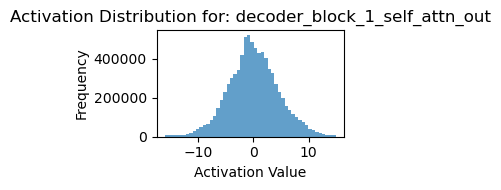

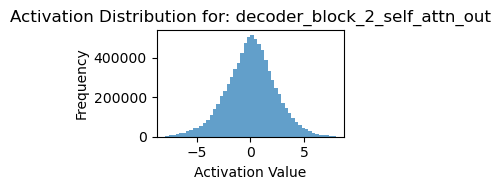

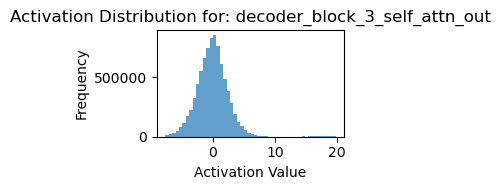

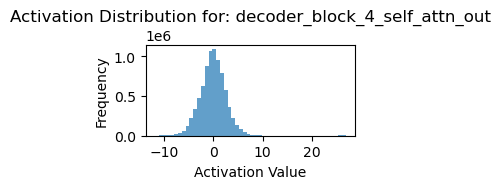

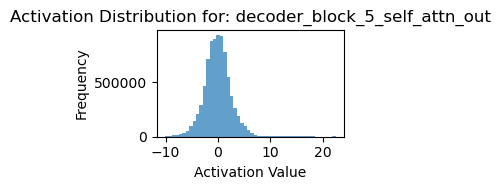

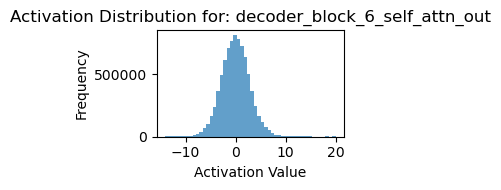

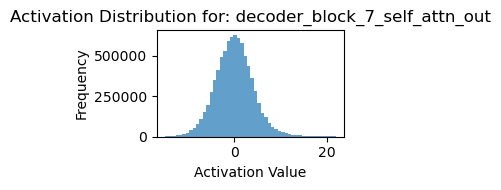

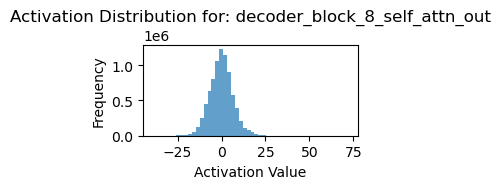

In [33]:
for name, activation in model.activations.items():
    if not ('decoder_block' in name and 'self_attn_out' in name):
        continue
    data = activation.flatten().float().cpu().numpy()
    lower, upper = np.percentile(data, [1, 99])  # clip outside 1%-99% range
    clipped_data = data[(data >= lower) & (data <= upper)]
    
    plt.figure(figsize=(3, 2))
    plt.hist(clipped_data, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f'Activation Distribution for: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

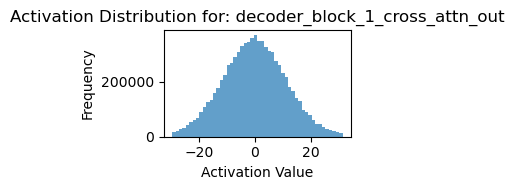

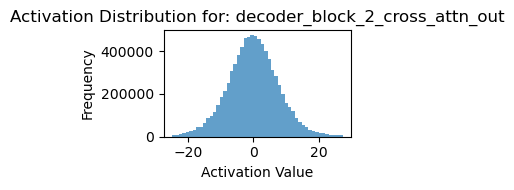

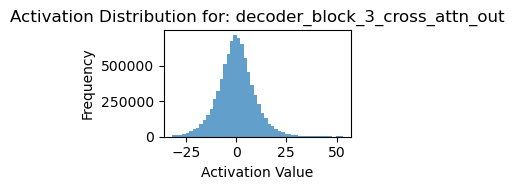

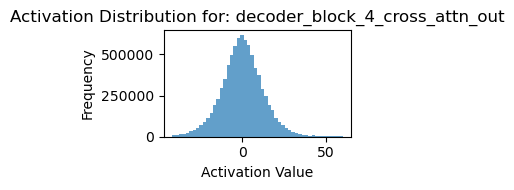

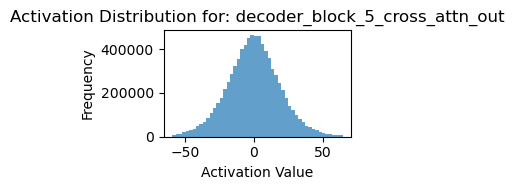

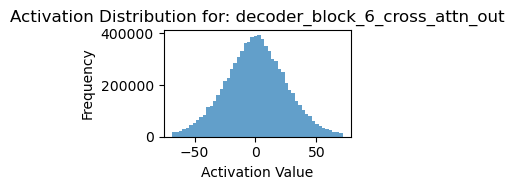

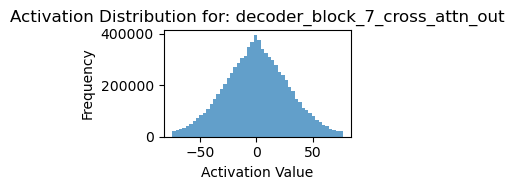

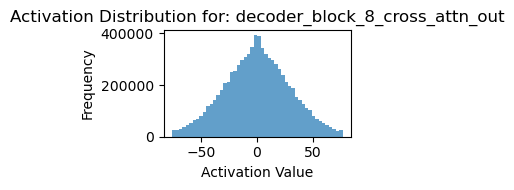

In [34]:
for name, activation in model.activations.items():
    if not ('decoder_block' in name and 'cross_attn_out' in name):
        continue
    data = activation.flatten().float().cpu().numpy()
    lower, upper = np.percentile(data, [1, 99])  # clip outside 1%-99% range
    clipped_data = data[(data >= lower) & (data <= upper)]
    
    plt.figure(figsize=(3, 2))
    plt.hist(clipped_data, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f'Activation Distribution for: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

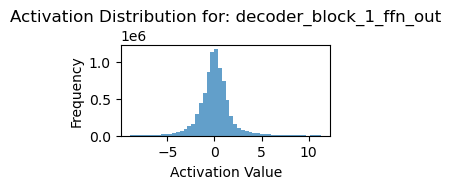

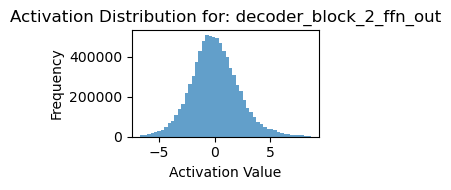

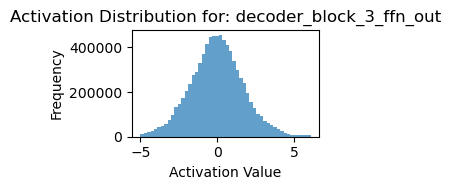

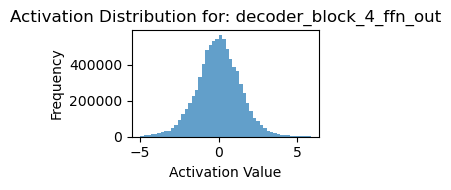

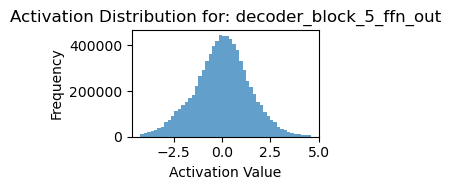

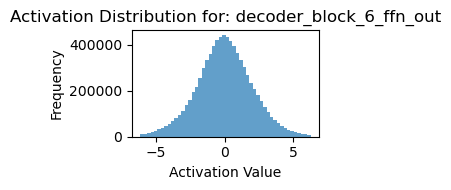

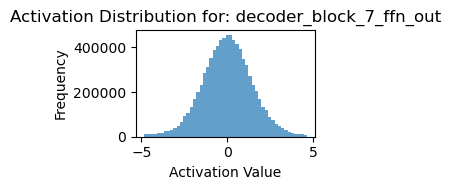

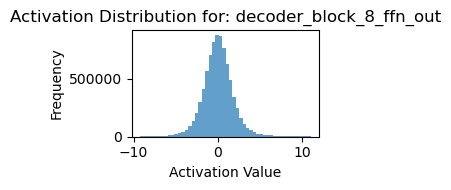

In [35]:
for name, activation in model.activations.items():
    if not ('decoder_block' in name and 'ffn_out' in name):
        continue
    data = activation.flatten().float().cpu().numpy()
    lower, upper = np.percentile(data, [1, 99])  # clip outside 1%-99% range
    clipped_data = data[(data >= lower) & (data <= upper)]
    
    plt.figure(figsize=(3, 2))
    plt.hist(clipped_data, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f'Activation Distribution for: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [36]:
torch.save(model.state_dict(), 'model_weights.pth')